In [95]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import sys
import random

In [96]:
sys.path.insert(0, '..')

In [97]:
from convlstm_classes import EncoderDecoderConvLSTM

In [98]:
future_steps = 30

In [99]:
dataset = torch.tensor(np.load('../../convlstm/splits/dataset.npy'))

In [100]:
dataset_norm = torch.tensor(np.load('../../convlstm/splits/dataset_normalized.npy'))

In [101]:
X = dataset_norm[:,:11,:,:,:]

y = dataset_norm[:,11:,:,:,:]

y_un = dataset[:,11:,:,:,:]

In [102]:
model = EncoderDecoderConvLSTM()

model.load_state_dict(torch.load('../best_model_params.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [103]:
full_len = len(X)

In [104]:
test_len = int(len(X) * 0.2)

In [105]:
for_mask = y_un[-test_len:,:,1]

In [106]:
X_test = X[-test_len:]

In [107]:
y_test = y[-test_len:,:,1]

In [108]:
y_pred = model(X_test).squeeze(2).detach().numpy()

In [109]:
y_no = torch.stack(future_steps * [X_test[:,-1,1]], 1)

In [110]:
y_test = np.ma.masked_where(for_mask.isnan(), y_test)

In [111]:
y_pred = np.ma.masked_where(for_mask.isnan(), y_pred)

In [112]:
y_no = np.ma.masked_where(for_mask.isnan(), y_no)

In [113]:
baseline_error = np.mean((y_no - y_test)**2)

In [114]:
model_error = np.mean((y_pred - y_test)**2)

In [115]:
print(f'Baseline mean squared error: {baseline_error:.5}')
print(f'Model mean squared error: {model_error:.5}')

Baseline mean squared error: 0.063958
Model mean squared error: 0.053012


In [116]:
baseline_error_by_day = [np.mean((y_no[:,i] - y_test[:,i])**2) for i in range(future_steps)]

In [117]:
model_error_by_day = [np.mean((y_pred[:,i] - y_test[:,i])**2) for i in range(future_steps)]

Text(0.5, 1.0, 'Mean squared error by day for baseline and ConvLSTM model')

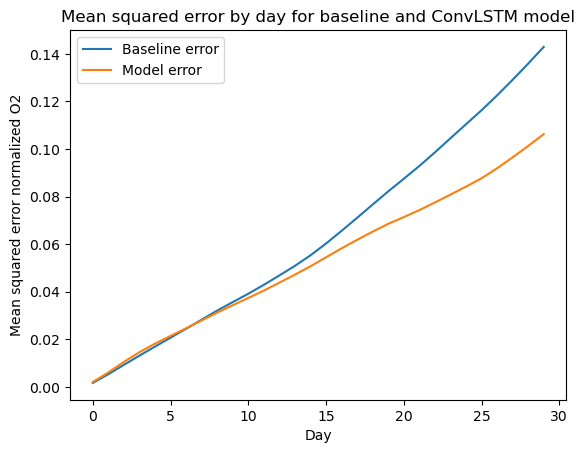

In [118]:
plt.plot(baseline_error_by_day, label='Baseline error')
plt.plot(model_error_by_day, label='Model error')
plt.xlabel('Day')
plt.ylabel('Mean squared error normalized O2')
plt.legend()
plt.savefig('mse.pdf', format='pdf')
plt.title('Mean squared error by day for baseline and ConvLSTM model')

In [119]:
np.random.seed(42)

In [120]:
non_masked_indices = [(i,j) for i in range(10) for j in range(20) if not y_test.mask[0,0,i,j]]

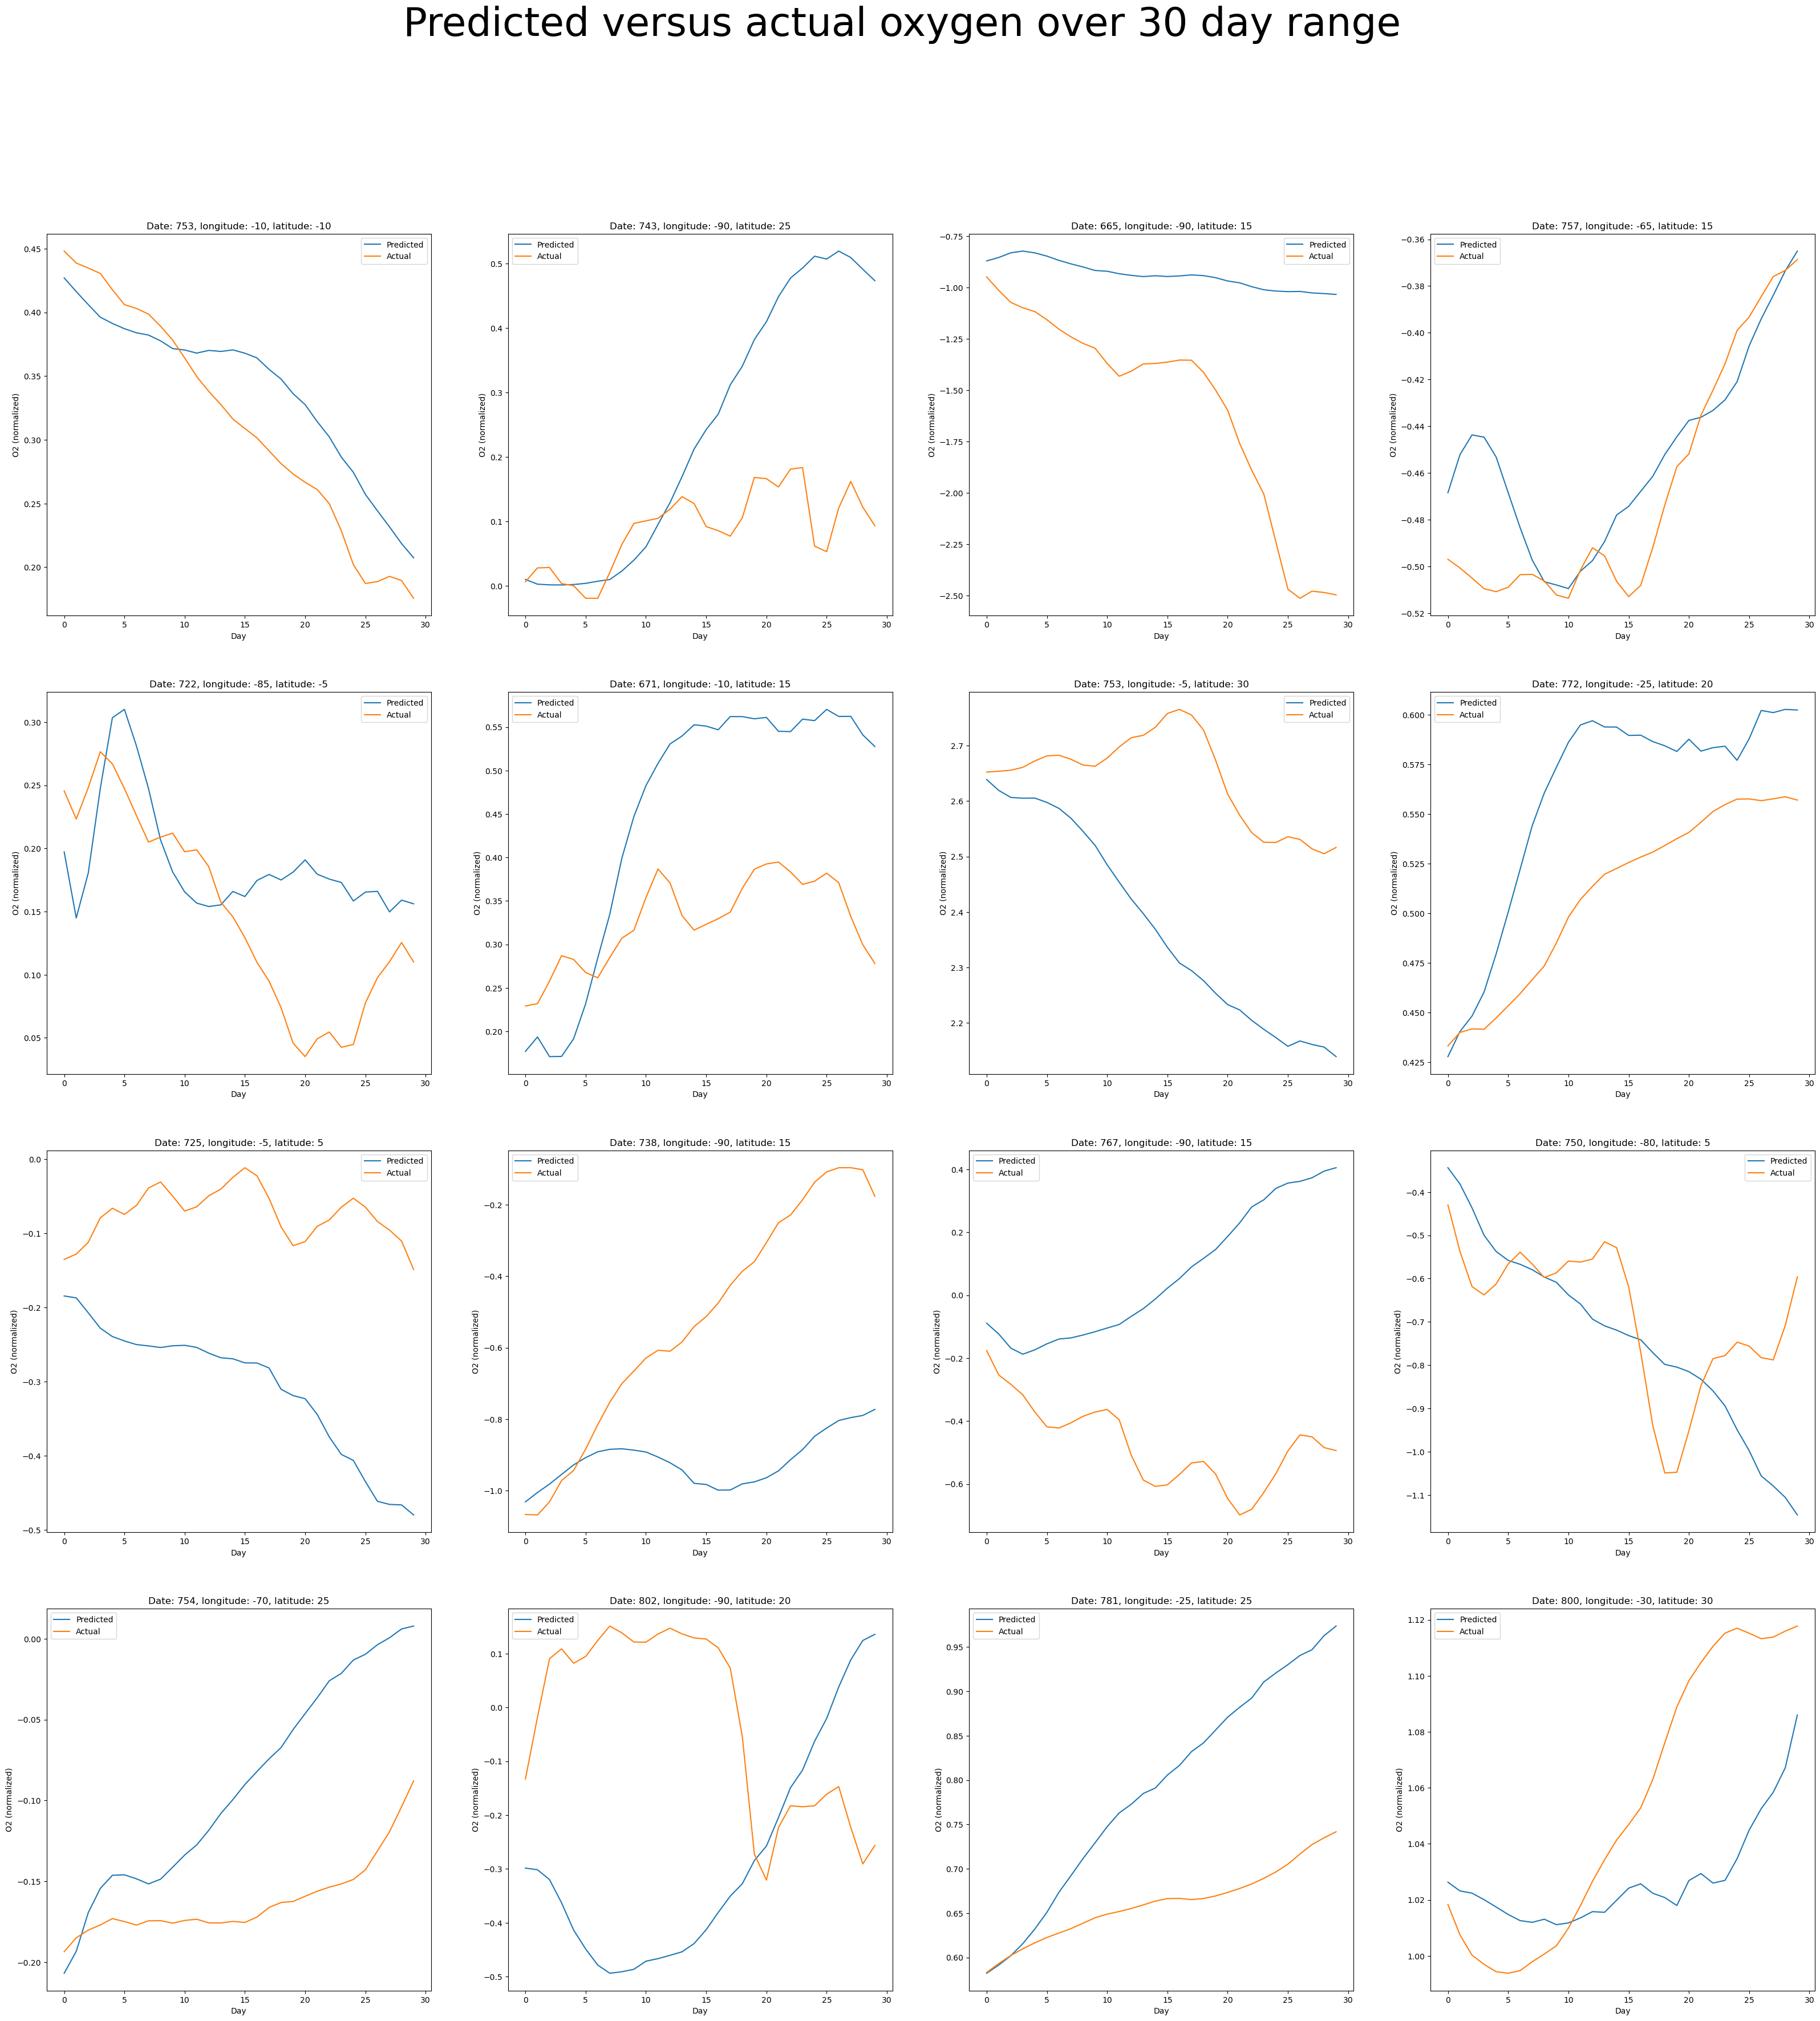

In [121]:
fig, axes = plt.subplots(4, 4, figsize=(40,40))
for i in range(16):
    lat, lon = random.choice(non_masked_indices)
    date = np.random.randint(low=0, high=test_len)
    true = y_test[date, :, lat, lon]
    pred = y_pred[date, :, lat, lon]
    
    ax = axes[i // 4][i % 4]
    ax.plot(range(30), pred, label='Predicted')
    ax.plot(range(30), true, label='Actual')
    
    ax.set_xlabel('Day')
    ax.set_ylabel('O2 (normalized)')
    ax.legend()
    ax.set_title(f'Date: {date + full_len - test_len}, longitude: {-95 + 5*lon}, latitude: {-10 + 5*lat}')

fig.suptitle('Predicted versus actual oxygen over 30 day range', fontsize=50)
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.savefig('predicted_o2.pdf', format='pdf', bbox_inches='tight')
plt.show()